In [22]:
from datasets import (
    load_dataset, 
    DatasetDict,
    concatenate_datasets
)
import numpy as np

seed = 1998
np.random.seed(seed=seed)

In [ ]:
dataset = load_dataset("BounharAbdelaziz/Terjman-v2-English-Darija-Dataset-10K-extended-all")

In [ ]:
dataset

In [ ]:
print(dataset['train'][0]['english'])

In [ ]:
print(dataset['train'][0]['fra_Latn'])
# print(dataset['train'][0]['ary_Arab'])

In [2]:
def check_indices_spread(indices):
    # Sort indices to analyze gaps
    sorted_idx = np.sort(indices)
    
    # Compute gaps between consecutive indices
    gaps = np.diff(sorted_idx)
    
    # Some useful metrics
    avg_gap = np.mean(gaps)
    min_gap = np.min(gaps)
    max_gap = np.max(gaps)
    consecutive_count = np.sum(gaps == 1)  # count of directly consecutive indices
    
    print(f"Average gap between indices: {avg_gap:.2f}")
    print(f"Min gap: {min_gap}")
    print(f"Max gap: {max_gap}")
    print(f"Number of consecutive pairs: {consecutive_count}")
    print(f"Percentage consecutive: {100 * consecutive_count/len(gaps):.1f}%")

In [46]:
# Load dataset
dataset = load_dataset("BounharAbdelaziz/Terjman-v2-English-Darija-Dataset-350K")
train_dataset = dataset['train'].shuffle(True)

# we keep only text bellow 4096 tokens
train_dataset = train_dataset.filter(lambda x: x['darija_tokens'] < 4096 and x['dataset_source'] != 'atlasia/DODa-audio-dataset-V3')

# extract doda pairs
doda_pairs = dataset['train'].filter(lambda x: x['dataset_source'] == 'atlasia/DODa-audio-dataset-V3')

# Extract token counts to use as weights
token_counts = np.array(train_dataset['darija_tokens'])

# Option 1: Linear weighting (directly proportional to token count)
# weights = token_counts

# Option 2: Exponential weighting (gives even more emphasis to high token counts)
weights = np.exp(token_counts / np.mean(token_counts))

# Normalize weights to probabilities
probabilities = weights / np.sum(weights)

# Sample indices with our weighted probabilities
TOTAL_SIZE = 10_000
weighted_random_indices = np.random.choice(
    len(train_dataset), 
    size=TOTAL_SIZE,
    replace=False,  # Without replacement
    p=probabilities  # Using our token-count-based probabilities
)

train_dataset = train_dataset.select(weighted_random_indices)

check_indices_spread(weighted_random_indices)

Average gap between indices: 34.18
Min gap: 1
Max gap: 280
Number of consecutive pairs: 289
Percentage consecutive: 2.9%


In [47]:
train_dataset

Dataset({
    features: ['english', 'darija_Arab', 'darija_Latn', 'dataset_source', 'id', 'role', 'darija_tokens', 'subtopic', 'topic', 'annotator_dialect'],
    num_rows: 10000
})

In [48]:
doda_pairs

Dataset({
    features: ['english', 'darija_Arab', 'darija_Latn', 'dataset_source', 'id', 'role', 'darija_tokens', 'subtopic', 'topic', 'annotator_dialect'],
    num_rows: 12134
})

In [49]:
train_dataset = concatenate_datasets([train_dataset, doda_pairs ])

In [50]:
train_dataset

Dataset({
    features: ['english', 'darija_Arab', 'darija_Latn', 'dataset_source', 'id', 'role', 'darija_tokens', 'subtopic', 'topic', 'annotator_dialect'],
    num_rows: 22134
})

In [51]:
train_dataset = train_dataset.select_columns(['english', 'darija_Arab', 'darija_Latn', 'dataset_source', 'darija_tokens'])

In [52]:
train_dataset

Dataset({
    features: ['english', 'darija_Arab', 'darija_Latn', 'dataset_source', 'darija_tokens'],
    num_rows: 22134
})

In [53]:
train_dataset = train_dataset.rename_column('darija_Arab', 'ary_Arab')
train_dataset = train_dataset.rename_column('darija_Latn', 'ary_Latn')
train_dataset = train_dataset.rename_column('darija_tokens', 'ary_tokens')

In [54]:
train_dataset

Dataset({
    features: ['english', 'ary_Arab', 'ary_Latn', 'dataset_source', 'ary_tokens'],
    num_rows: 22134
})

In [55]:
# reorder
train_dataset = train_dataset.select_columns(['english', 'ary_Arab', 'ary_Latn', 'ary_tokens', 'dataset_source'])

In [56]:
total_ary_tokens = sum(train_dataset['ary_tokens'])
print(f'total_ary_tokens: {total_ary_tokens}')

total_ary_tokens: 8310992


In [57]:
new_dataset = DatasetDict({
    "train": train_dataset,
    "test": dataset['test']
})

In [58]:
new_dataset

DatasetDict({
    train: Dataset({
        features: ['english', 'ary_Arab', 'ary_Latn', 'ary_tokens', 'dataset_source'],
        num_rows: 22134
    })
    test: Dataset({
        features: ['english', 'darija_Arab', 'darija_Latn', 'dataset_source', 'id', 'role', 'darija_tokens', 'subtopic', 'topic', 'annotator_dialect'],
        num_rows: 850
    })
})

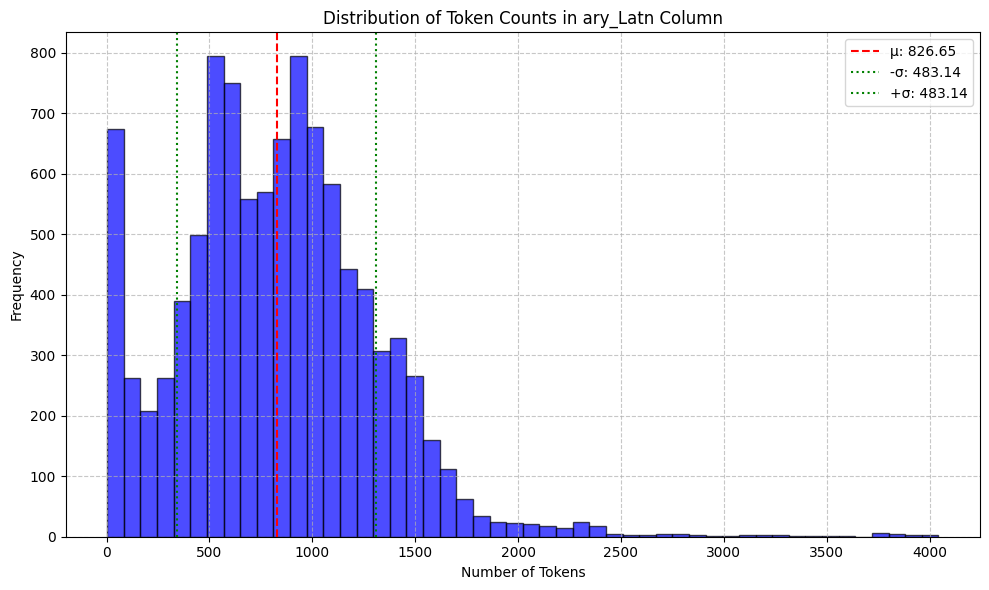

In [45]:
import matplotlib.pyplot as plt

# Assuming 'train' is your dataset variable
# Extract token counts from the ary_Latn column
token_counts = train_dataset['ary_tokens']

# Calculate statistics on plotted data
mean = np.mean(token_counts)
std = np.std(token_counts)

# Create a simple histogram
plt.figure(figsize=(10, 6))
plt.hist(token_counts, bins=50, alpha=0.7, color='blue', edgecolor='black')

# Add vertical lines for mean and standard deviation
plt.axvline(
    mean, 
    color="red", 
    linestyle="--", 
    label=f"μ: {mean:.2f}"
)
if (mean - std) > 0:
    plt.axvline(
        mean - std, 
        color="green", 
        linestyle=":", 
        label=f"-σ: {std:.2f}"
    )
plt.axvline(
    mean + std, 
    color="green", 
    linestyle=":", 
    label=f"+σ: {std:.2f}"
)
    
plt.title('Distribution of Token Counts in ary_Latn Column')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### DODA skews the data distribution

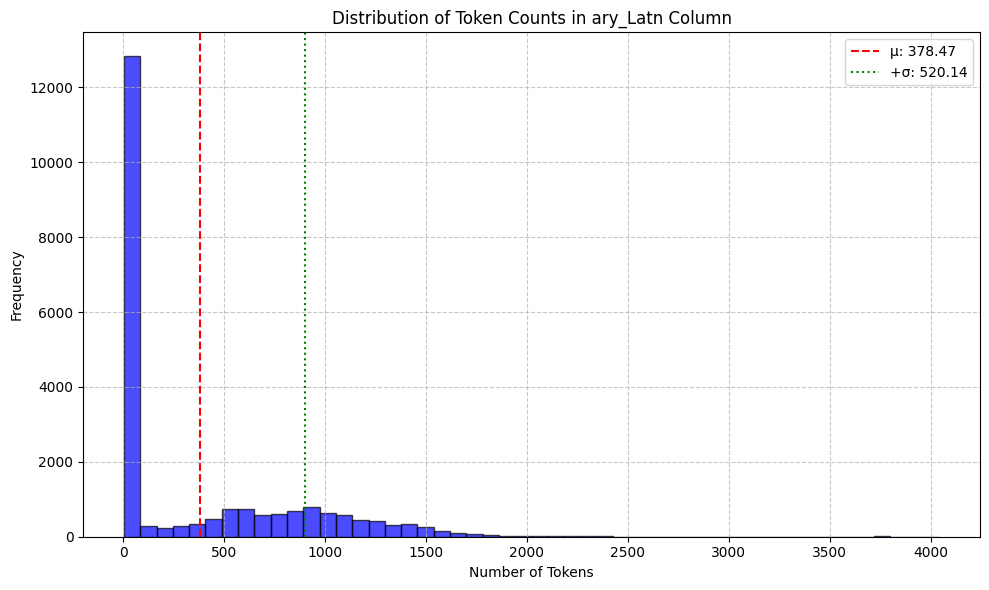

In [33]:
import matplotlib.pyplot as plt

# Assuming 'train' is your dataset variable
# Extract token counts from the ary_Latn column
token_counts = train_dataset['ary_tokens']

# Calculate statistics on plotted data
mean = np.mean(token_counts)
std = np.std(token_counts)

# Create a simple histogram
plt.figure(figsize=(10, 6))
plt.hist(token_counts, bins=50, alpha=0.7, color='blue', edgecolor='black')

# Add vertical lines for mean and standard deviation
plt.axvline(
    mean, 
    color="red", 
    linestyle="--", 
    label=f"μ: {mean:.2f}"
)
if (mean - std) > 0:
    plt.axvline(
        mean - std, 
        color="green", 
        linestyle=":", 
        label=f"-σ: {std:.2f}"
    )
plt.axvline(
    mean + std, 
    color="green", 
    linestyle=":", 
    label=f"+σ: {std:.2f}"
)
    
plt.title('Distribution of Token Counts in ary_Latn Column')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [59]:
train_dataset.push_to_hub("BounharAbdelaziz/Terjman-v2-English-Darija-Dataset-10K", config_name="train", private=True, commit_message=f'Pushed {TOTAL_SIZE} samples + DODa with total ary_Arab tokens={total_ary_tokens}, max_tokens=4096')
dataset['test'].push_to_hub("BounharAbdelaziz/Terjman-v2-English-Darija-Dataset-10K", config_name="test", private=True, commit_message=f'Pushed {TOTAL_SIZE} samples + DODa with total ary_Arab tokens={total_ary_tokens}, max_tokens=4096')

Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/BounharAbdelaziz/Terjman-v2-English-Darija-Dataset-10K/commit/e3888793e30ee3f722f25adc5d81bf4765bad83d', commit_message='Pushed 10000 samples + DODa with total ary_Arab tokens=8310992, max_tokens=4096', commit_description='', oid='e3888793e30ee3f722f25adc5d81bf4765bad83d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/BounharAbdelaziz/Terjman-v2-English-Darija-Dataset-10K', endpoint='https://huggingface.co', repo_type='dataset', repo_id='BounharAbdelaziz/Terjman-v2-English-Darija-Dataset-10K'), pr_revision=None, pr_num=None)

# Without filter < 2048

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'train' is your dataset variable
# Extract token counts from the ary_Latn column
token_counts = train_dataset['ary_tokens']

# Calculate statistics on plotted data
mean = np.mean(token_counts)
std = np.std(token_counts)

# Create a simple histogram
plt.figure(figsize=(10, 6))
plt.hist(token_counts, bins=50, alpha=0.7, color='blue', edgecolor='black')

# Add vertical lines for mean and standard deviation
plt.axvline(
    mean, 
    color="red", 
    linestyle="--", 
    label=f"μ: {mean:.2f}"
)
if (mean - std) > 0:
    plt.axvline(
        mean - std, 
        color="green", 
        linestyle=":", 
        label=f"-σ: {std:.2f}"
    )
plt.axvline(
    mean + std, 
    color="green", 
    linestyle=":", 
    label=f"+σ: {std:.2f}"
)
    
plt.title('Distribution of Token Counts in ary_Latn Column')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
train_dataset.push_to_hub("BounharAbdelaziz/Terjman-v2-English-Darija-Dataset-10K", config_name="train", private=True, commit_message=f'Pushed {TOTAL_SIZE} samples with total ary_Arab tokens={total_ary_tokens}')
dataset['test'].push_to_hub("BounharAbdelaziz/Terjman-v2-English-Darija-Dataset-10K", config_name="test", private=True, commit_message=f'Pushed {TOTAL_SIZE} samples with total ary_Arab tokens={total_ary_tokens}')

# Transliterating ary_Arab to ary_Latn
Not perfect...

In [ ]:
def transliterate_darija(arabic_text):
    """
    Transliterate Moroccan Darija from Arabic script to Latin script.
    Preserves Latin numbers.
    """
    # Define the mapping dictionary (Arabic character to Latin)
    ar_to_latin = {
        # Arabic letters
        'ا': 'a',
        'أ': 'a',
        'إ': 'i',
        'آ': 'a',
        'ب': 'b',
        'ت': 't',
        'ث': 't',
        'ج': 'j',
        'ح': '7',  # Using 7 for ح as commonly done
        'خ': 'kh',
        'د': 'd',
        'ذ': 'd',
        'ر': 'r',
        'ز': 'z',
        'س': 'ss',
        'ش': 'ch',
        'ص': 's',
        'ض': 'd',
        'ط': 't',
        'ظ': 'd',
        'ع': '3',  # Using 3 for ع as commonly done
        'غ': 'gh',
        'ف': 'f',
        'ق': '9',  # Using 9 for ق as commonly done
        'ك': 'k',
        'ل': 'l',
        'م': 'm',
        'ن': 'n',
        'ه': 'h',
        'و': 'w',
        'ي': 'i',
        'ى': 'a',
        'ة': 'a',
        
        # Vowels (harakat)
        'َ': 'a',  # Fatha
        'ُ': 'u',  # Damma
        'ِ': 'i',  # Kasra
        'ّ': '',   # Shadda (doubling handled separately)
        'ْ': '',   # Sukun (no vowel)
        'ً': 'an', # Tanween Fath
        'ٌ': 'un', # Tanween Damm
        'ٍ': 'in', # Tanween Kasr
        
        # Additional Darija-specific characters
        'ڭ': 'g',
        'ڤ': 'v',
        'پ': 'p',
        'چ': 'g',
        'ژ': 'j',
        
        # Arabic Numbers
        '٠': '0',
        '١': '1',
        '٢': '2',
        '٣': '3',
        '٤': '4',
        '٥': '5',
        '٦': '6',
        '٧': '7',
        '٨': '8',
        '٩': '9',
        
        # Punctuation
        '؟': '?',
        '،': ',',
        '؛': ';',
    }
    
    # Handle shadda (character doubling)
    result = ''
    i = 0
    while i < len(arabic_text):
        if i + 1 < len(arabic_text) and arabic_text[i + 1] == 'ّ':  # If next char is shadda
            char = arabic_text[i]
            if char in ar_to_latin:
                # Double the transliterated character
                result += ar_to_latin[char] * 2
            else:
                # Keep it as is if not in our mapping
                result += char
            i += 2  # Skip the current char and the shadda
        else:
            # Regular transliteration for characters without shadda
            char = arabic_text[i]
            if char in ar_to_latin:
                result += ar_to_latin[char]
            else:
                # Check if it's a Latin number or other character to preserve
                if char.isdigit() or char in ' .,:;!?-_()[]{}/\\@#$%^&*+=<>|"\'`~':
                    result += char
                else:
                    # For any other unrecognized character, keep it as is
                    result += char
            i += 1
    
    return result

In [ ]:
# Test with some examples
examples = [
    "مرحبا", 
    "كيف حالك؟", 
    "شكرا", 
    "واش بغيتي شي حاجة؟",  
    "قهوة",  
    "الحمد لله",  
    "شنو هاد الشي؟", 
    "زوين بزّاف", 
    "القسم 5 و القسم 6",  
]

print("Moroccan Darija Transliteration Examples:")
print("-" * 40)
for example in examples:
    latinized = transliterate_darija(example)
    print(f"Arabic: {example}")
    print(f"Latin:  {latinized}")
    print("-" * 40)